In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import langevin
import langevin_cached_model as lcm
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [8]:
# function to calculate A and B from the dataset
def OUanalytic1(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult1(data,deltat):
    A, dA, B ,dB = OUanalytic1(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [9]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [10]:
A,D = 1.0,0.5 # tau = 2
delta_t_list=np.linspace(0.01,3,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))

In [11]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

result_Bayes_array = None
for delta_t in delta_t_list:
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult1(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

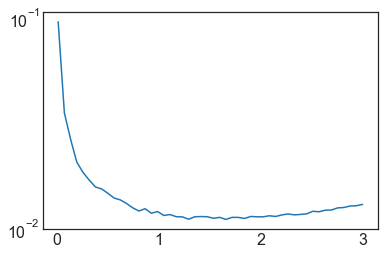

In [24]:
plt.semilogy(delta_t_list,result_Bayes_array.T[3]/2)

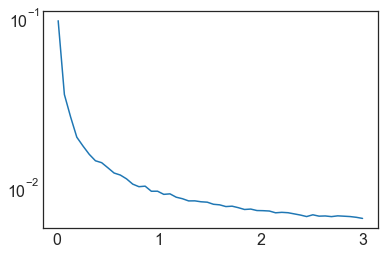

In [13]:
plt.semilogy(delta_t_list,result_Bayes_array.T[1])

In [31]:
A,D = 1.0,0.5
tau_real = D/A
delta_t_list=np.linspace(0.01,3,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))
pick_delta = 7
print(delta_t_list[pick_delta])
data = langevin.time_series(A=A, D=D, delta_t=delta_t_list[pick_delta], N=N)

0.43714285714285717


In [15]:
# compile model for reuse
sm = lcm.OU_DA()
sm.samples=20000

In [16]:
trace = sm.run(x=data,
                d_bound=5,
                a_bound=5,
                delta_t=delta_t_list[pick_delta],
                N=50000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1960.60draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8825925593402891, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8959878522058231, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c18d43400>,
      dtype=object)

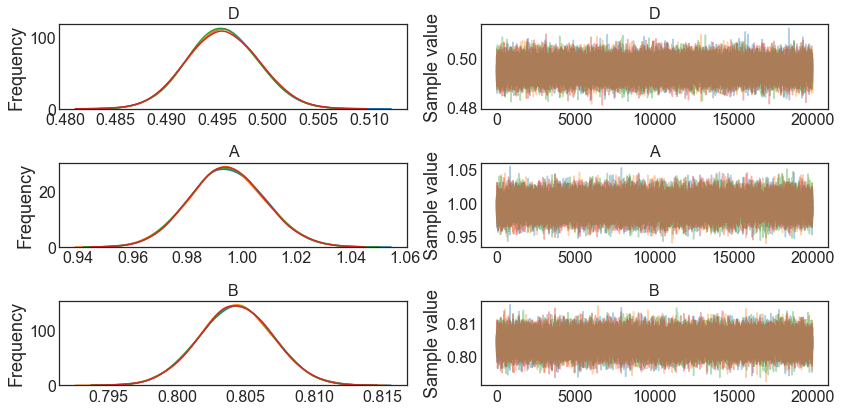

In [17]:
pm.traceplot(trace)

In [18]:
result_array = None
for delta_t in delta_t_list:
    print(delta_t)
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    trace = sm.run(x=data,
                d_bound=5,
                a_bound=5,
                delta_t=delta_t,
                N=50000)
    a_mean = trace['A'].mean()
    d_mean = trace['D'].mean()
    a_std = trace['A'].std()
    d_std = trace['D'].std()
    results = [a_mean,a_std,d_mean,d_std]
    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))

0.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:46<00:00, 1747.25draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8882681512999796, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8953066352731074, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833029871837091, but should 

0.07102040816326531


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:48<00:00, 1688.86draws/s]
The acceptance probability does not match the target. It is 0.9016392195737472, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8821948661543247, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.1320408163265306


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1910.87draws/s]
The acceptance probability does not match the target. It is 0.895597241051011, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8932797957182365, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8852908380703508, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.19306122448979593


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:40<00:00, 2039.28draws/s]
The acceptance probability does not match the target. It is 0.8813160584553517, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.2540816326530612


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1858.34draws/s]
The acceptance probability does not match the target. It is 0.8835815969332244, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8954468741941896, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.31510204081632653


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1977.63draws/s]
The acceptance probability does not match the target. It is 0.8881326226019207, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8938269586233764, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8827563897456157, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8831268020815765, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.37612244897959185


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1899.06draws/s]
The acceptance probability does not match the target. It is 0.8974071686136056, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8858710973872167, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.43714285714285717


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 695.47draws/s] 
The acceptance probability does not match the target. It is 0.8955861826439657, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815546618962946, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.4981632653061225


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1846.01draws/s]
The acceptance probability does not match the target. It is 0.8858241183355575, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.888060057198962, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920820706420768, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8824972337979693, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.5591836734693878


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1965.59draws/s]
The acceptance probability does not match the target. It is 0.8965539498664895, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880515461840819, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815260919435197, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865764979328042, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.6202040816326531


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1980.30draws/s]
The acceptance probability does not match the target. It is 0.8909666516315383, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886007989211506, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8978918949664222, but should be close to 0.8. Try to increase the number of tuning steps.


0.6812244897959184


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1959.95draws/s]
The acceptance probability does not match the target. It is 0.8890387762849234, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8808225801541877, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.7422448979591837


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1933.56draws/s]
The acceptance probability does not match the target. It is 0.8828149902841207, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868201628000493, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795065789563018, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.8032653061224491


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1955.22draws/s]
The acceptance probability does not match the target. It is 0.883662285024825, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796995056957835, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8886052133052263, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.8642857142857143


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:40<00:00, 2003.85draws/s]
The acceptance probability does not match the target. It is 0.8913278951199928, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795654256532387, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886765031798241, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.9253061224489797


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1983.58draws/s]
The acceptance probability does not match the target. It is 0.8920415400941114, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.986326530612245


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1969.00draws/s]
The acceptance probability does not match the target. It is 0.8883604549057676, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8939949984607994, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8808072889380596, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.0473469387755103


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1788.10draws/s]
The acceptance probability does not match the target. It is 0.8921577428817442, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8890812402925267, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.898597780786218, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.1083673469387756


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1987.36draws/s]
The acceptance probability does not match the target. It is 0.8795180658371504, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.1693877551020408


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1979.08draws/s]
The acceptance probability does not match the target. It is 0.8848843518582075, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.894622673710391, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.230408163265306


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 516.80draws/s] 
The acceptance probability does not match the target. It is 0.8851764213097223, but should be close to 0.8. Try to increase the number of tuning steps.


1.2914285714285716


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1901.04draws/s]
The acceptance probability does not match the target. It is 0.8813290925721065, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8839333595549114, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8810314745438104, but should be close to 0.8. Try to increase the number of tuning steps.


1.3524489795918369


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1985.32draws/s]
The acceptance probability does not match the target. It is 0.8912257320672597, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8790931303378325, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.4134693877551021


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1928.46draws/s]
The acceptance probability does not match the target. It is 0.8903933552572185, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916249016518963, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.4744897959183674


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1995.89draws/s]
The acceptance probability does not match the target. It is 0.8786434646556828, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8863503109160176, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.5355102040816326


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1818.89draws/s]
The acceptance probability does not match the target. It is 0.8805586663444817, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.903119121842896, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.5965306122448981


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1970.79draws/s]
The acceptance probability does not match the target. It is 0.8802811109988519, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8848638843666006, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.6575510204081634


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1931.22draws/s]
The acceptance probability does not match the target. It is 0.8853272764908371, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8818059987324629, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8896061688746676, but should be close to 0.8. Try to increase the number of tuning steps.


1.7185714285714286


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1794.72draws/s]
The acceptance probability does not match the target. It is 0.8890562623597706, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8935898504664426, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8851040971528884, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.779591836734694


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1918.35draws/s]
The acceptance probability does not match the target. It is 0.8851000852592821, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915221195999886, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.8406122448979594


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1896.21draws/s]
The acceptance probability does not match the target. It is 0.8933174726644676, but should be close to 0.8. Try to increase the number of tuning steps.


1.9016326530612246


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:47<00:00, 1730.79draws/s]
The acceptance probability does not match the target. It is 0.8849464950010443, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916277725423601, but should be close to 0.8. Try to increase the number of tuning steps.


1.96265306122449


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1795.07draws/s]
The acceptance probability does not match the target. It is 0.8846767548795129, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.890763381375362, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855578093622354, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.023673469387755


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:48<00:00, 1687.25draws/s]
The acceptance probability does not match the target. It is 0.8892825128686777, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8892869599911463, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8912365507727408, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.0846938775510204


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1878.50draws/s]
The acceptance probability does not match the target. It is 0.8788757072110791, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915515088197797, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.1457142857142855


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1917.57draws/s]
The acceptance probability does not match the target. It is 0.8852377312013986, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.206734693877551


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:40<00:00, 2008.21draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.2677551020408164


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1802.50draws/s]
The acceptance probability does not match the target. It is 0.8862038505690746, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8798293425758795, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8988105646549481, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.3287755102040815


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1786.61draws/s]
The acceptance probability does not match the target. It is 0.8987239960182903, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8874103405426073, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8925616277962887, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.389795918367347


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:57<00:00, 385.00draws/s] 
The acceptance probability does not match the target. It is 0.8876728815107909, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916991451505748, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9440647784242481, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.450816326530612


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:41<00:00, 1953.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.5118367346938775


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1837.06draws/s]
The acceptance probability does not match the target. It is 0.8911986243758317, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.572857142857143


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1907.69draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.633877551020408


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1788.87draws/s]
The acceptance probability does not match the target. It is 0.8939764116379225, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8817538950885971, but should be close to 0.8. Try to increase the number of tuning steps.


2.6948979591836735


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:48<00:00, 1694.62draws/s]
The acceptance probability does not match the target. It is 0.8797428477972498, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.901265128493574, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8900257004117281, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.7559183673469385


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:46<00:00, 1775.96draws/s]
The acceptance probability does not match the target. It is 0.8856941896982301, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813050495869892, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8892995694578653, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.816938775510204


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1815.70draws/s]
The acceptance probability does not match the target. It is 0.8848805400735594, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.8779591836734695


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1874.42draws/s]
The acceptance probability does not match the target. It is 0.8866724502014426, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8804805514721452, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8860218415464954, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.9389795918367345


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1911.53draws/s]
The acceptance probability does not match the target. It is 0.8795972270302812, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


3.0


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:57<00:00, 1429.49draws/s]
The acceptance probability does not match the target. It is 0.8793671292337496, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9126729113828015, but should be close to 0.8. Try to increase the number of tuning steps.


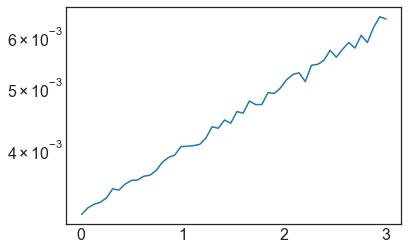

In [19]:
plt.semilogy(delta_t_list,result_array.T[3])

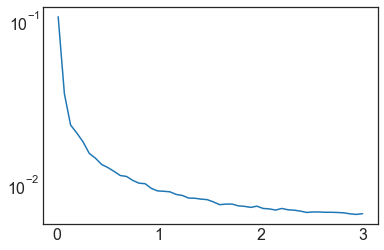

In [20]:
plt.semilogy(delta_t_list,result_array.T[1])

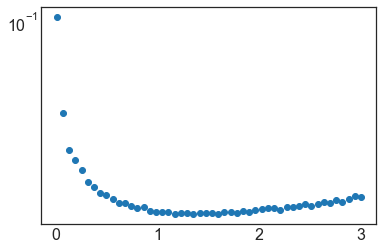

In [28]:
dtau = np.sqrt(result_array.T[1]**2/D**2+A**2/D**4*result_array.T[3]**2)
plt.semilogy(delta_t_list,dtau/tau_real,"o")

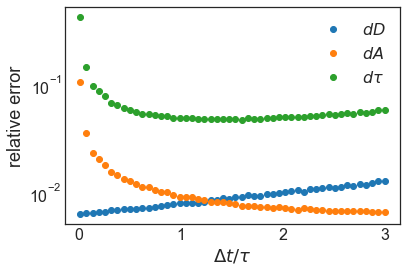

In [32]:
plt.semilogy(delta_t_list,result_array.T[3]/D,"o",label=r"$dD$")
plt.semilogy(delta_t_list,result_array.T[1]/A,"o",label=r'$dA$')
plt.semilogy(delta_t_list,dtau/tau_real,"o",label=r'$d\tau$')
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend()

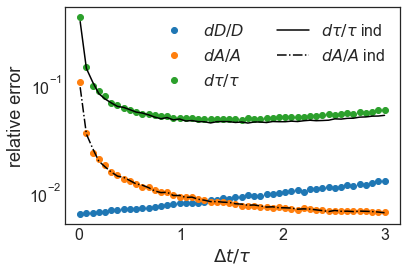

In [38]:
plt.semilogy(delta_t_list,result_array.T[3]/D,"o",label=r"$dD/D$")
plt.semilogy(delta_t_list,result_array.T[1]/A,"o",label=r'$dA/A$')
plt.semilogy(delta_t_list,dtau/tau_real,"o",label=r'$d\tau/\tau$')
plt.semilogy(delta_t_list,result_Bayes_array.T[3]/tau_real,color="k",label=r"$d\tau/\tau$ ind")
plt.semilogy(delta_t_list,result_Bayes_array.T[1]/A,"-.",color="k",label=r"$dA/A$ ind")
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend(ncol=2)
plt.savefig("optimaldt_1_05.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")